In [1]:
# !pip install folium dask xarray h5py

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import h5py
import xarray as xr
from datetime import datetime, timedelta
import dask.array as da
import matplotlib.pyplot as plt
from tqdm import tqdm
path = '/nfsscratch/Users/wndrsn/CALIPSOATL09'

In [2]:
CALIPSOFiles = sorted(glob.glob(os.path.join(path, '**/*.hdf'), recursive=True))
atlfiles = sorted(glob.glob(os.path.join(path, '**/*.h5',), recursive=True))
print(len(CALIPSOFiles),len(atlfiles))

38 38


# Load ATL09 and CALIPSO Files

In [3]:
def gps_to_datetime(gps_seconds):
    gps_epoch = datetime(2018, 1, 1)
    gps_time = gps_epoch + timedelta(seconds=gps_seconds)
    return gps_time

def XRenderMODIS(filename):
    try:
        dataset = xr.open_dataset(filename, engine="netcdf4", drop_variables = full_list)
        lat = np.array(dataset['Latitude']).flatten()
        long = np.array(dataset['Longitude']).flatten()
        time = np.array(dataset['Profile_Time']).flatten()
        ProfileID = np.array(dataset['Profile_ID']).flatten()
        lat = pd.DataFrame(lat, columns=['Lat0'])
        long = pd.DataFrame(long, columns=['Long0'])
        time = pd.DataFrame(time, columns=['Time0'])
        ProfileID = pd.DataFrame(ProfileID, columns=['Profile_ID'])
        data = pd.concat((lat, long, time,ProfileID), axis=1)
        data['Time0'] = data['Time0'].apply(days_to_date)
        filename_df = pd.DataFrame([os.path.basename(filename)] * len(data), columns=['filename'])
        data = pd.concat([data, filename_df], axis=1)
        dataset.close()
        return data
    except Exception as e:
        print(f'Error reading {filename} due to {e}')
        
def days_to_date(input_str):
    gps_epoch = datetime(1993, 1, 1)
    gps_time = gps_epoch + timedelta(seconds=input_str)
    return gps_time

def HDFtoDF(filename, chunk_size=408):
    try:
        with h5py.File(filename, 'r') as file:

            latitude_data = da.from_array(file['profile_1']['high_rate']['latitude'],chunks = chunk_size)
            longitude_data = da.from_array(file['profile_1']['high_rate']['longitude'], chunks=chunk_size)
            delta_time_data = da.from_array(file['profile_1']['high_rate']['delta_time'], chunks=chunk_size)

            df = pd.DataFrame({
                'Lat0': latitude_data.compute(),
                'Long0': longitude_data.compute(),
                'Time0': delta_time_data.compute()
            })
            df['Time0'] = df['Time0'].apply(gps_to_datetime)
            filename_df = pd.DataFrame([os.path.basename(filename)] * len(df), columns=['filename'])
            df = pd.concat([df, filename_df], axis=1)
             
        return df

    except Exception as e:
        print(f'Error reading {filename} due to {e}')

    
full_list = ['Profile_UTC_Time', 'Day_Night_Flag', 'Minimum_Laser_Energy_532', 'Column_Optical_Depth_Cloud_532', 'Column_Optical_Depth_Cloud_Uncertainty_532', 'Column_Optical_Depth_Tropospheric_Aerosols_532', 'Column_Optical_Depth_Tropospheric_Aerosols_Uncertainty_532', 'Column_Optical_Depth_Stratospheric_Aerosols_532', 'Column_Optical_Depth_Stratospheric_Aerosols_Uncertainty_532', 'Column_Optical_Depth_Tropospheric_Aerosols_1064', 'Column_Optical_Depth_Tropospheric_Aerosols_Uncertainty_1064', 'Column_Optical_Depth_Stratospheric_Aerosols_1064', 'Column_Optical_Depth_Stratospheric_Aerosols_Uncertainty_1064', 'Column_Feature_Fraction', 'Column_Integrated_Attenuated_Backscatter_532', 'Column_IAB_Cumulative_Probability', 'Tropopause_Height', 'Tropopause_Temperature', 'Temperature', 'Pressure', 'Molecular_Number_Density', 'Ozone_Number_Density', 'Relative_Humidity', 'IGBP_Surface_Type', 'Surface_Elevation_Statistics', 'Surface_Winds', 'Samples_Averaged', 'Aerosol_Layer_Fraction', 'Cloud_Layer_Fraction', 'Atmospheric_Volume_Description', 'Extinction_QC_Flag_532', 'Extinction_QC_Flag_1064', 'CAD_Score', 'Total_Backscatter_Coefficient_532', 'Total_Backscatter_Coefficient_Uncertainty_532', 'Perpendicular_Backscatter_Coefficient_532', 'Perpendicular_Backscatter_Coefficient_Uncertainty_532', 'Particulate_Depolarization_Ratio_Profile_532', 'Particulate_Depolarization_Ratio_Uncertainty_532', 'Extinction_Coefficient_532', 'Extinction_Coefficient_Uncertainty_532', 'Aerosol_Multiple_Scattering_Profile_532', 'Backscatter_Coefficient_1064', 'Backscatter_Coefficient_Uncertainty_1064', 'Extinction_Coefficient_1064', 'Extinction_Coefficient_Uncertainty_1064', 'Aerosol_Multiple_Scattering_Profile_1064', 'Surface_Top_Altitude_532', 'Surface_Base_Altitude_532', 'Surface_Integrated_Attenuated_Backscatter_532', 'Surface_532_Integrated_Depolarization_Ratio', 'Surface_532_Integrated_Attenuated_Color_Ratio', 'Surface_Detection_Flags_532', 'Surface_Detection_Confidence_532', 'Surface_Overlying_Integrated_Attenuated_Backscatter_532', 'Surface_Scaled_RMS_Background_532', 'Surface_Peak_Signal_532', 'Surface_Detections_333m_532', 'Surface_Detections_1km_532', 'Surface_Top_Altitude_1064', 'Surface_Base_Altitude_1064', 'Surface_Integrated_Attenuated_Backscatter_1064', 'Surface_1064_Integrated_Depolarization_Ratio', 'Surface_1064_Integrated_Attenuated_Color_Ratio', 'Surface_Detection_Flags_1064', 'Surface_Detection_Confidence_1064', 'Surface_Overlying_Integrated_Attenuated_Backscatter_1064', 'Surface_Scaled_RMS_Background_1064', 'Surface_Peak_Signal_1064', 'Surface_Detections_333m_1064', 'Surface_Detections_1km_1064']
CALIPSO_data = pd.concat([XRenderMODIS(file) for file in tqdm(CALIPSOFiles)])
ATL_data = pd.concat([HDFtoDF(file) for file in tqdm(atlfiles)])

  0%|          | 0/38 [00:00<?, ?it/s]

100%|██████████| 38/38 [00:23<00:00,  1.61it/s]


# Save Raw Data

In [5]:
CALIPSO_Data = pd.concat([CALIPSO_data['Lat0'],CALIPSO_data['Long0'],CALIPSO_data['Time0']])
atl_data = pd.concat([ATL_data['Lat0'],ATL_data['Long0'],ATL_data['Time0']])
CALIPSO_Data.to_csv('CALIPSO_Data.csv')
atl_data.to_csv('atl_data.csv')

# Compare Datasets

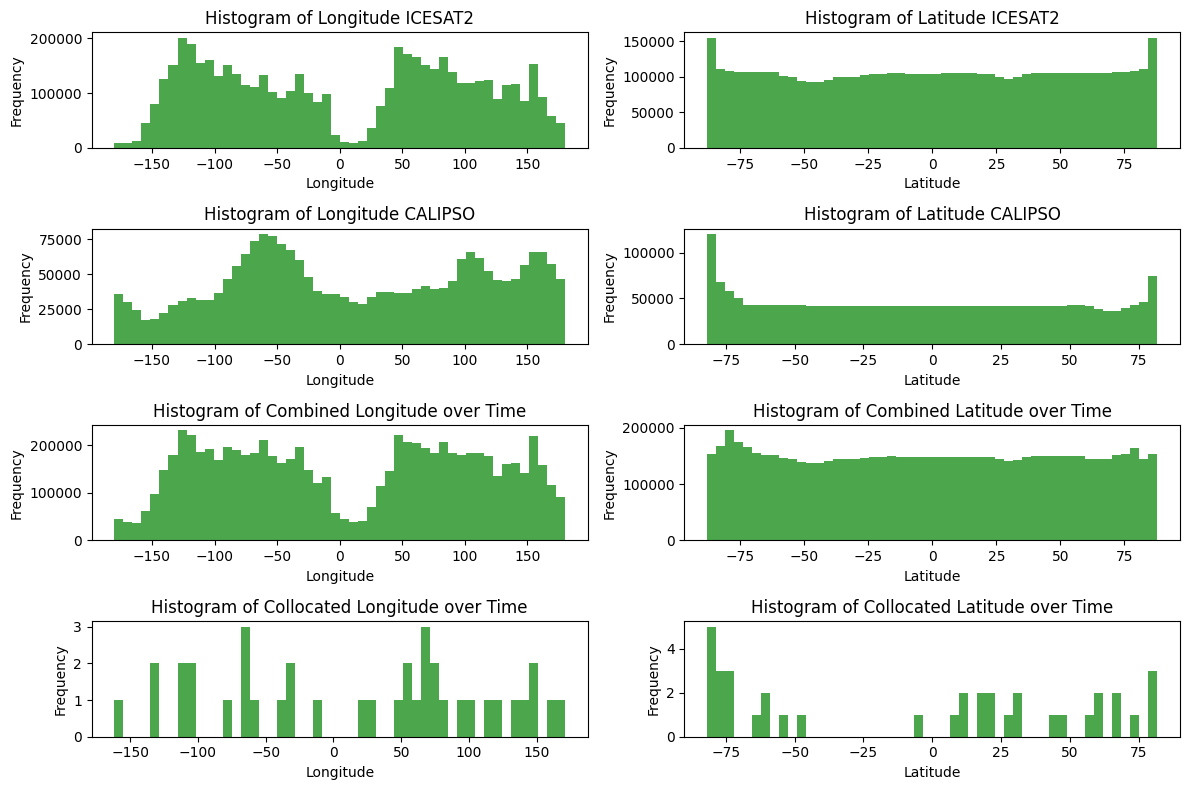

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CALIPSO_Data = pd.read_csv('CALIPSO_Data.csv')
ATL_data = pd.read_csv('atl_data.csv')
# Combine latitudes from both datasets
all_latitudes = np.array(pd.concat([CALIPSO_data['Lat0'], ATL_data['Lat0']]))

# Combine longitudes from both datasets
all_longitudes = np.array(pd.concat([CALIPSO_data['Long0'], ATL_data['Long0']]))
collocations_data = pd.read_csv('/Users/wndrsn/ICESAT2_CALIPSO_Collocations.csv', usecols=['Lat0_left', 'Long0_left'])

collocations_data = pd.read_csv('/Users/wndrsn/ICESAT2_CALIPSO_Collocations.csv')
collocations_data = collocations_data.drop_duplicates(subset = 'filename_left', keep= 'first')
collocations_data = collocations_data.drop_duplicates(subset = 'filename_right', keep= 'first')
colats = collocations_data['Lat0_left']
colongs = collocations_data['Long0_left']

# Create a 2x2 grid of subplots
plt.figure(figsize=(12, 8))



# Subplot 1: Histogram of Longitude ICESAT2
plt.subplot(4, 2, 1)
plt.hist(ATL_data['Long0'], bins=50, color='green', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Longitude ICESAT2')

# Subplot 2: Histogram of Latitude CALIPSO
plt.subplot(4, 2, 2)
plt.hist(ATL_data['Lat0'], bins=50, color='green', alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Histogram of Latitude ICESAT2')


# Subplot 3: Histogram of Longitude CALIPSO
plt.subplot(4, 2, 3)
plt.hist(CALIPSO_data['Long0'], bins=50, color='green', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Longitude CALIPSO')
# Subplot 4: Histogram of Latitude ICESAT2

plt.subplot(4, 2, 4)
plt.hist(CALIPSO_data['Lat0'], bins=50, color='green', alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Histogram of Latitude CALIPSO')

plt.subplot(4, 2, 5)
plt.hist(all_longitudes, bins=50, color='green', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Longitude over Time')

# Additional subplots for overall latitude and longitude
plt.subplot(4, 2, 6)
plt.hist(all_latitudes, bins=50, color='green', alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Histogram of Combined Latitude over Time')

plt.subplot(4, 2, 7)
plt.hist(colongs, bins=50, color='green', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Frequency')
plt.title('Histogram of Collocated Longitude over Time')

plt.subplot(4, 2, 8)
plt.hist(colats, bins=50, color='green', alpha=0.7)
plt.xlabel('Latitude')
plt.ylabel('Frequency')
plt.title('Histogram of Collocated Latitude over Time')




# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


# Plot Collocation Data on a map 

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from IPython.display import display

collocations_data = pd.read_csv('/Users/wndrsn/ICESAT2_CALIPSO_Collocations.csv')
collocations_data = collocations_data.drop_duplicates(subset = 'filename_left', keep= 'first')
collocations_data = collocations_data.drop_duplicates(subset = 'filename_right', keep= 'first')
map_center = [collocations_data['Lat0_right'].mean(), collocations_data['Long0_right'].mean()]
mymap = folium.Map(location=map_center, zoom_start=2)

heat_data = [[row['Lat0_right'], row['Long0_right']] for index, row in collocations_data.iterrows()]

HeatMap(heat_data).add_to(mymap)

display(mymap)
# Save the map as an image (PNG)
mymap.save('my_map.html')  # Save as HTML
mymap.save('my_map.png')   # Save as PNG

# Display the saved image
print("Map saved as 'my_map.png'")